# 1 - Уменьшение палитры изображения 
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.
Задание можно выполнять на своих картинках

In [152]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, title):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

In [153]:
import warnings
warnings.filterwarnings('ignore')

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

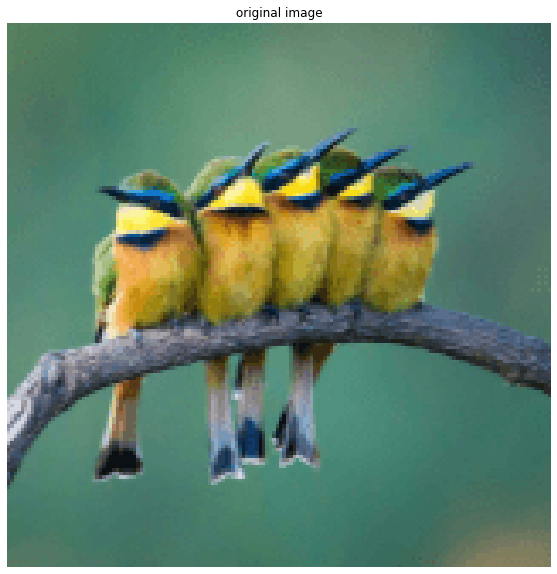

In [154]:
img = cv2.imread('img_2.png') # считать картинку
draw_picture(img, 'original image') # нарисовать картинку

In [155]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from skimage.metrics import structural_similarity as ssim
import numpy as np

X = img.reshape((-1,3)).astype(np.float32)

random_state = 123
K_1 = [2, 3, 10, 20]
K = range(2, 21)
results = {
    'KMeans': [],
    'DBSCAN': [],
    'AgglomerativeClustering': []
}

## 1.1 KMeans

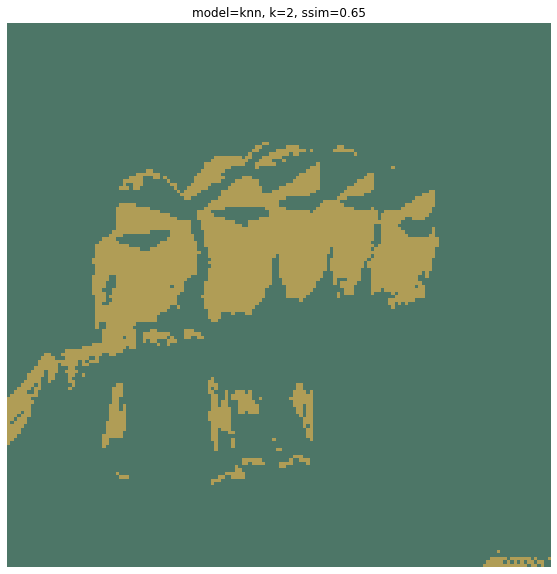

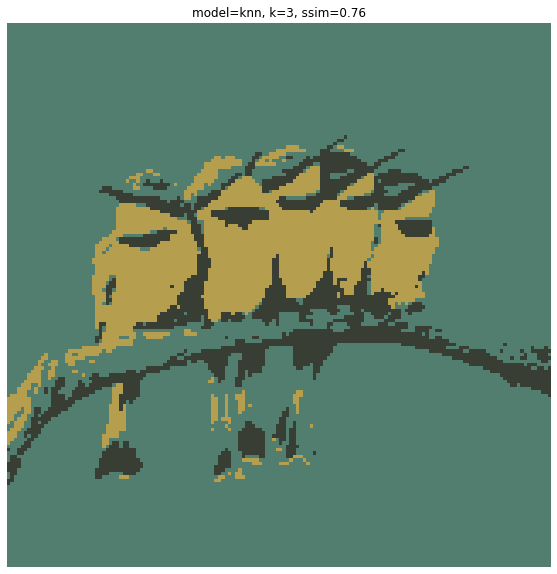

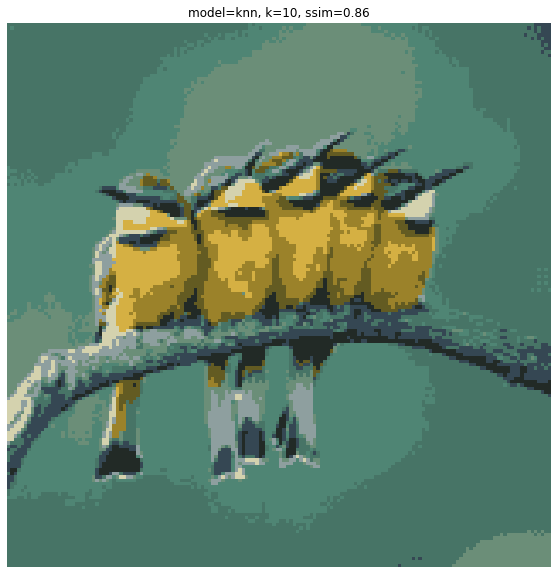

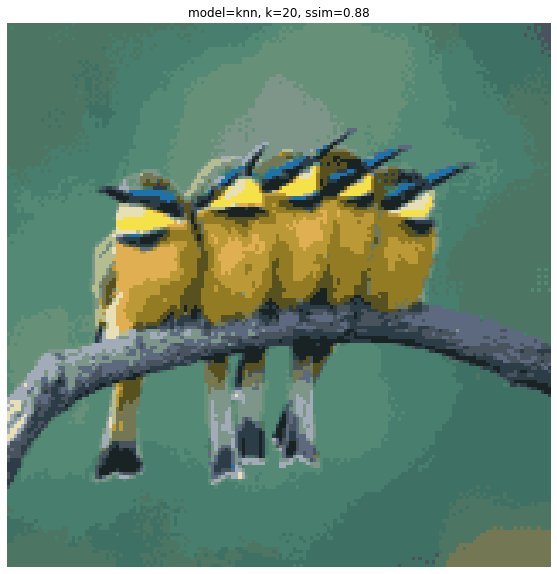

In [156]:
for k in K:
    knn = KMeans(n_clusters=k, random_state=random_state).fit(X)
    center = knn.cluster_centers_
    center = np.uint8(center)
    shape = center.shape
    label = knn.labels_
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    _ssim = round(ssim(img, result_image, channel_axis=-1, multichannel=True), 2)
    results['KMeans'].append(_ssim)
    if k in K_1:
        draw_picture(result_image, f'model=knn, k={k}, ssim={_ssim}')

## 1.2 DBSCAN

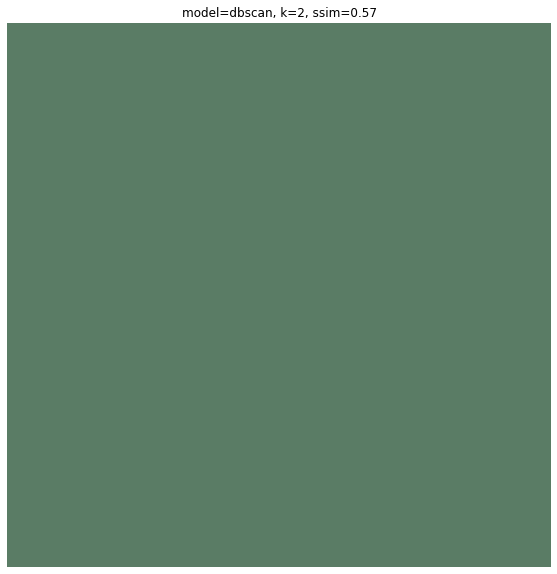

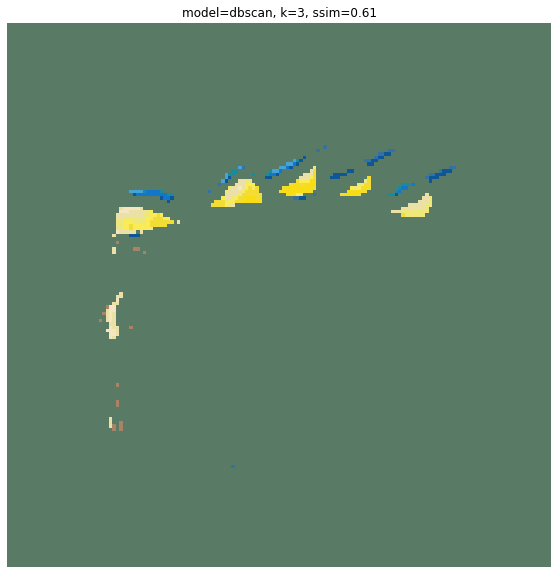

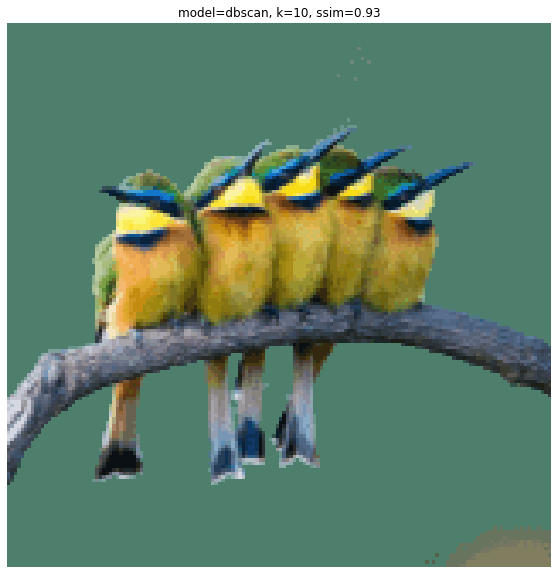

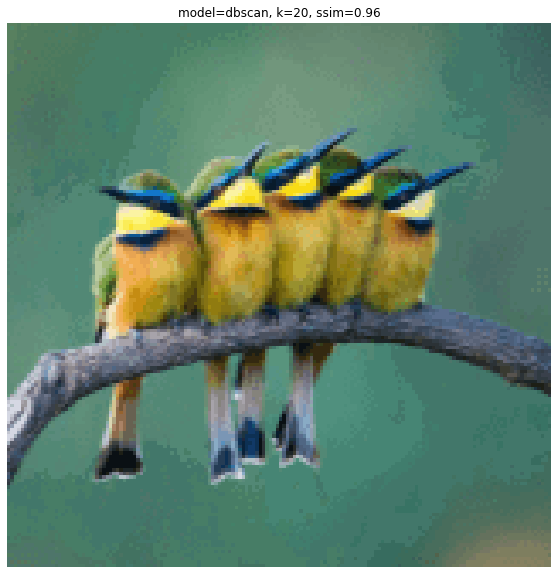

In [157]:
for k in K:
    dbscan = DBSCAN(eps=100 / k).fit(X)
    label = dbscan.labels_
    mx_index = np.max(label)
    label[label == -1] = mx_index + 1
    center = np.array([np.mean(X[label == x], axis=0) for x in range(0, mx_index + 2)])
    colors = center[label]

    res = np.uint8(colors.reshape((-1, 3)))
    result_image = res.reshape((img.shape))

    _ssim = round(ssim(img, result_image, channel_axis=-1, multichannel=True), 2)
    results['DBSCAN'].append(_ssim)
    if k in K_1:
        draw_picture(result_image, f'model=dbscan, k={k}, ssim={_ssim}')

## 1.3 AgglomerativeClustering

In [158]:
from joblib import Memory
memory = Memory('.', verbose=0)

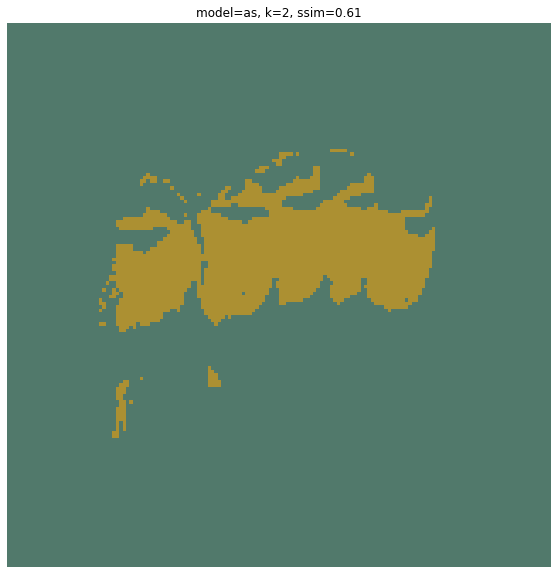

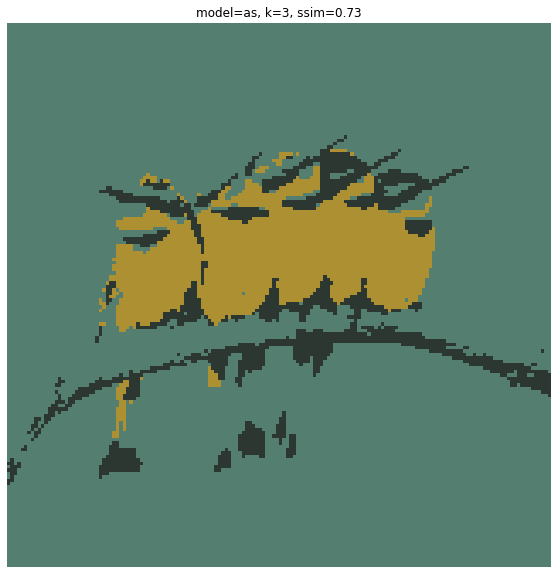

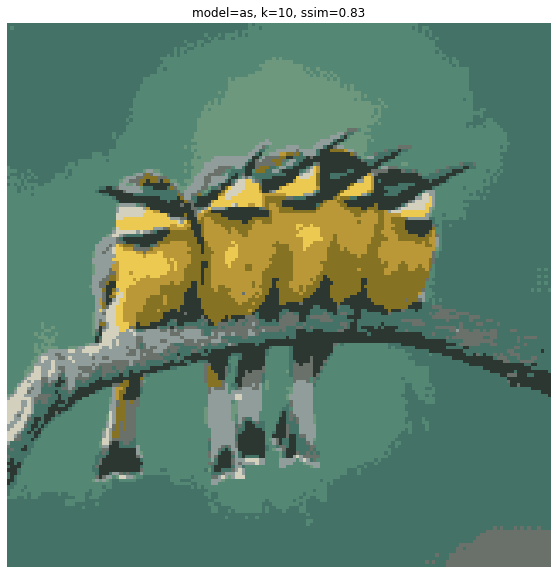

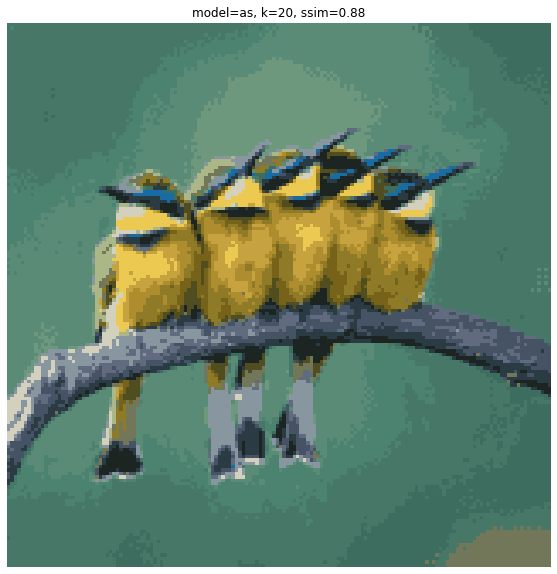

In [159]:
for k in K:
    ac = AgglomerativeClustering(n_clusters=k, memory=memory).fit(X)
    label = ac.labels_
    mx_index = np.max(label)
    label[label == -1] = mx_index + 1
    center = np.array([np.mean(X[label == x], axis=0) for x in range(0, mx_index + 2)])
    colors = center[label]

    res = np.uint8(colors.reshape((-1, 3)))
    result_image = res.reshape((img.shape))

    _ssim = round(ssim(img, result_image, channel_axis=-1, multichannel=True), 2)
    results['AgglomerativeClustering'].append(_ssim)
    if k in K_1:
        draw_picture(result_image, f'model=as, k={k}, ssim={_ssim}')

## 1.4 Сравним модели

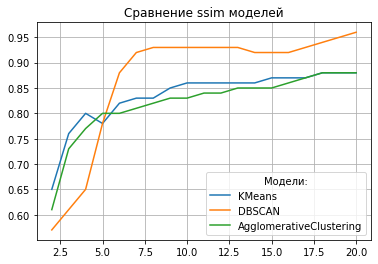

In [160]:
for model in results:
    plt.plot(K, results[model], label=model)
plt.grid()
plt.legend(title='Модели:')
plt.title('Сравнение ssim моделей')
plt.show()

# 2 - Пишем K-Means сами

Написать K-Means и сравнить с моделькой из под sklearn.

Задание оценивается в 5 баллов

In [178]:
from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=10000, centers=[(1, 1), (5, 5), (10, 10)], random_state=42, cluster_std=10)

## 2.1. Самописный KMeans

In [223]:
class KMeans:
    def __init__(self, n_clusters, random_state=42, eps=0.1, max_iters=300):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.centers = None
        self.data = None
        self.labels = None
        self.eps = eps
        self.max_iters = max_iters

    def __init_centers(self):
        np.random.RandomState(self.random_state)
        self.centers = self.data[np.random.choice(self.data.shape[0], self.n_clusters, replace=False), :]

    def __update_centers(self):
        for i in range(self.n_clusters):
            cluster_data = self.data[self.labels == i]
            if len(cluster_data) == 0:
                continue
            self.centers[i] = np.mean(cluster_data, axis=0)

    def __cluster(self):
        centers_tensor = np.tile(self.centers[None, :, :], (self.data.shape[0], 1, 1))
        data_tensor = np.tile(self.data[:, None, :], (1, self.n_clusters, 1))
        distances = np.linalg.norm(data_tensor - centers_tensor, axis=2)
        self.labels = np.argmin(distances, axis=1)

    def fit(self, data):
        self.data = data
        self.__init_centers()
        iter_counter = 0
        while True:
            centers = np.copy(self.centers)
            self.__cluster()
            self.__update_centers()
            if (np.mean(np.linalg.norm(centers - self.centers, axis=1)) < self.eps
                    or iter_counter >= self.max_iters):
                break
            iter_counter += 1

In [224]:
my_model = KMeans(n_clusters=3)
my_model.fit(x)

## 2.2. KMeans from sklearn

In [225]:
from sklearn.cluster import KMeans

sk_model = KMeans(n_clusters=3, max_iter=300, n_init=10)
sk_model.fit(x)

## 2.3. Сравнение моделей

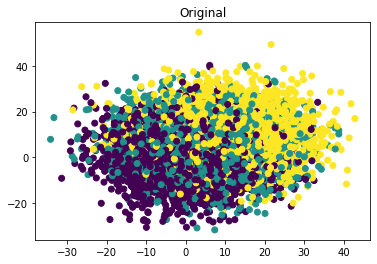

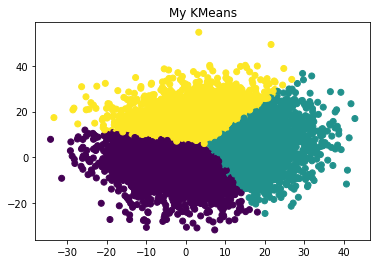

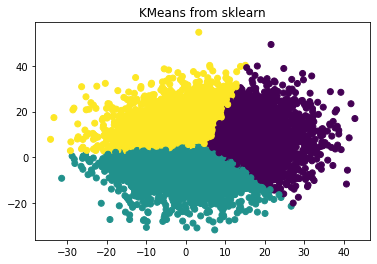

In [226]:
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title('Original')
plt.show()

plt.scatter(x[:, 0], x[:, 1], c=my_model.labels)
plt.title('My KMeans')
plt.show()

plt.scatter(x[:, 0], x[:, 1], c=sk_model.labels_)
plt.title('KMeans from sklearn')
plt.show()

### 2.3.1. Accuracy classification score

In [228]:
from sklearn.metrics import accuracy_score

my_accuracy_score = accuracy_score(my_model.labels, y)
sk_accuracy_score = accuracy_score(sk_model.labels_, y)

print('my_accuracy_score =', my_accuracy_score)
print('sk_accuracy_score =', sk_accuracy_score)

my_accuracy_score = 0.4299
sk_accuracy_score = 0.2801


### 2.3.2 Compute the precision.

In [230]:
from sklearn.metrics import precision_score

my_precision_score = precision_score(my_model.labels, y, average='macro')
sk_precision_score = precision_score(sk_model.labels_, y, average='macro')

print('my_precision_score =', my_precision_score)
print('sk_precision_score =', sk_precision_score)

my_precision_score = 0.4298843801596716
sk_precision_score = 0.2801108845137663


# 3 - Пишем DBSCAN сами (дополнительное задание на 5 баллов)

Аналогично предыдудщему заданию

## 3.1. Самописный DBSCAN

In [258]:
from collections import deque

class MYDBSCAN:
    def __init__(self, eps = 0.3, min_points = 3):
        self.eps = eps
        self.min_points = min_points
        self.labels_ = None

    def fit(self, X):
        self.labels_ = - np.ones(X.shape[0])
        cluster = -1
        for i, x in enumerate(X):
            if self.labels_[i] != -1:
                continue
            neighbours = (np.linalg.norm(X - x, axis=1) < self.eps).nonzero()[0]
            if len(neighbours) < self.min_points:
                continue

            cluster += 1
            q = deque([i])
            while q:
                elem_idx = q[0]
                elem = X[elem_idx]
                neighbours_idx = ((np.linalg.norm(X - elem, axis=1) < self.eps)).nonzero()[0]
                neighbours_unused = ((np.linalg.norm(X - elem, axis=1) < self.eps) & (self.labels_ == -1)).nonzero()[0]
                self.labels_[neighbours_unused] = cluster
                q.popleft()

                if len(neighbours_idx) >= self.min_points:
                    q.extend(neighbours_unused)

In [262]:
my_dbscan = MYDBSCAN()
my_dbscan.fit(x)

## 3.2. DBSCAN from sklearn

In [263]:
sk_dbscan = DBSCAN()
sk_dbscan.fit(x)

DBSCAN()

## 3.3. Сравнение моделей

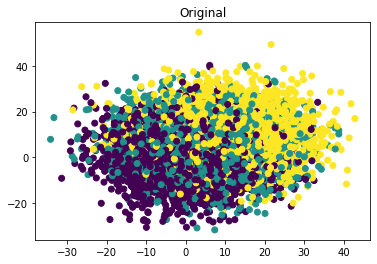

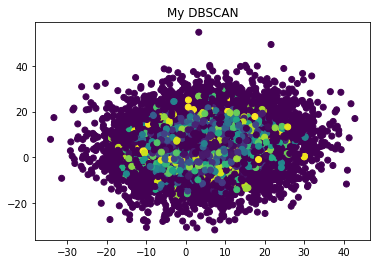

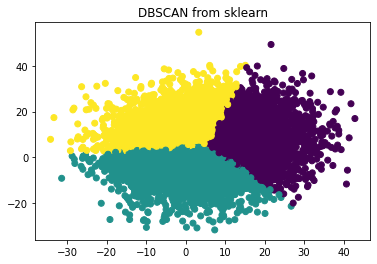

In [264]:
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title('Original')
plt.show()

plt.scatter(x[:, 0], x[:, 1], c=my_dbscan.labels_)
plt.title('My DBSCAN')
plt.show()

plt.scatter(x[:, 0], x[:, 1], c=sk_model.labels_)
plt.title('DBSCAN from sklearn')
plt.show()

### 3.3.1. Accuracy classification score

In [265]:
from sklearn.metrics import accuracy_score

my_accuracy_score = accuracy_score(my_dbscan.labels_, y)
sk_accuracy_score = accuracy_score(sk_dbscan.labels_, y)

print('my_accuracy_score =', my_accuracy_score)
print('sk_accuracy_score =', sk_accuracy_score)

my_accuracy_score = 0.0182
sk_accuracy_score = 0.1788


### 3.3.2 Compute the precision.

In [266]:
from sklearn.metrics import precision_score

my_precision_score = precision_score(my_model.labels, y, average='macro')
sk_precision_score = precision_score(sk_model.labels_, y, average='macro')

print('my_precision_score =', my_precision_score)
print('sk_precision_score =', sk_precision_score)

my_precision_score = 0.23010072452956154
sk_precision_score = 0.2801108845137663
